# Proof of concept - online rhat

In [1]:
import blackjax
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
from blackjax.diagnostics import potential_scale_reduction
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [2]:
Theta = namedtuple('Theta', ['beta', 'sigsq'])

In [3]:
WelfordState = namedtuple("WelfordState", ["K", "Ex", "Ex2", "n"])

def welford_init(K) -> WelfordState:
  return WelfordState(K, 0., 0., 0)

def welford_add(state: WelfordState, x: float) -> WelfordState:
  return WelfordState(state.K, state.Ex + x - state.K, state.Ex2 + (x - state.K)**2, state.n + 1)

def welford_mean(state: WelfordState) -> WelfordState:
  return state.K + state.Ex / state.n

def welford_var(state: WelfordState) -> WelfordState:
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [4]:
ExtendedState = namedtuple("ExtendedState", ['state', 'rng_key', 'welford_state'])

In [5]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

In [7]:
num_samples = 500
warmup_iter = 500
num_chains = 5
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(0), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key):
  k1, k2 = jax.random.split(key)
  return Theta(beta=jax.random.normal(key=k1, shape=(p,)), sigsq=jax.random.normal(key=k2))

In [8]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logprob_fn, num_steps=warmup_iter, progress_bar=True)
final_warmup_state, kernel, info = warmup.run(warmup_key, make_initial_pos(init_key))

Running window adaptation



CPU times: user 3.89 s, sys: 48.7 ms, total: 3.94 s
Wall time: 3.9 s


In [9]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs]
)
initial_states = jax.vmap(lambda p: blackjax.nuts.init(p, logprob_fn))(initial_positions)

In [10]:
# sense check logprob_fn
[logprob_fn(final_warmup_state.position), jax.vmap(logprob_fn)(initial_positions)]

[Array(-190.69493, dtype=float32),
 Array([-190.5587 , -192.4972 , -194.80263, -190.87244, -190.28656],      dtype=float32)]

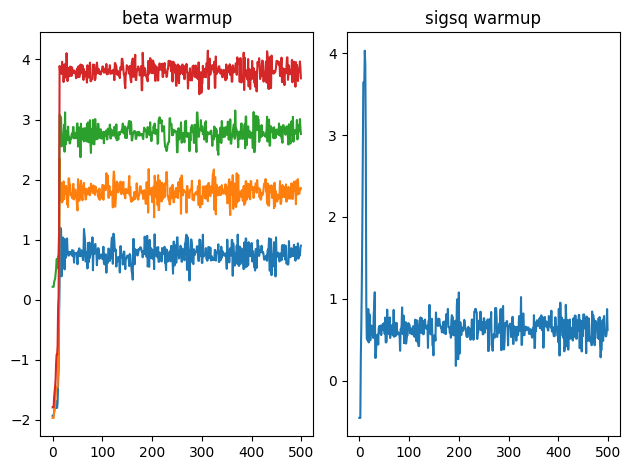

In [11]:
plt.subplot(1,2,1)
plt.plot(info[0].position.beta)
plt.title('beta warmup')
plt.subplot(1,2,2)
plt.plot(info[0].position.sigsq)
plt.title('sigsq warmup')
plt.tight_layout()

In [12]:
def jax_lax_fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val

In [15]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(i, extended_state):
        i_key, carry_key = jax.random.split(extended_state.rng_key)
        chain_state, _ = kernel(i_key, extended_state.state)
        e = X @ chain_state.position.beta - y
        elpd_contrib = -0.5 * (
            jnp.log(2 * jnp.pi)
            + jnp.log(chain_state.position.sigsq)
            + jnp.dot(e, e)/chain_state.position.sigsq
        )
        carry_welford_state = welford_add(extended_state.welford_state, elpd_contrib)
        carry_state = ExtendedState(chain_state, carry_key, carry_welford_state)
        return carry_state  # we'll eventually drop chain state and return None instead
    # split the chain
    initial_state_1h = ExtendedState(initial_state, rng_key, welford_init(0))
    carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    initial_state_2h = ExtendedState(initial_state_1h.state, initial_state_1h.rng_key, welford_init(0))
    carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    # combine the chain halves for debugging (we'll drop this later)
    #states = jnp.vstack((states_1h, states_2h))
    return carry_state_1h, carry_state_2h #, states

In [16]:
inference_loop(sampling_key, kernel, final_warmup_state, num_samples)

(ExtendedState(state=HMCState(position=Theta(beta=Array([0.8277628, 1.5127527, 2.8520634, 3.9402685], dtype=float32), sigsq=Array(0.64826894, dtype=float32)), potential_energy=Array(192.31618, dtype=float32), potential_energy_grad=Theta(beta=Array([  2.8077207, -13.579062 ,   2.771546 ,   6.8802266], dtype=float32), sigsq=Array(0.631957, dtype=float32))), rng_key=Array([4205885708, 1313433263], dtype=uint32), welford_state=WelfordState(K=Array(0, dtype=int32, weak_type=True), Ex=Array(-40264.15, dtype=float32), Ex2=Array(7004402., dtype=float32), n=Array(250, dtype=int32, weak_type=True))),
 ExtendedState(state=HMCState(position=Theta(beta=Array([0.7355648, 1.9075307, 2.7324188, 3.8594103], dtype=float32), sigsq=Array(0.90825325, dtype=float32)), potential_energy=Array(192.54556, dtype=float32), potential_energy_grad=Theta(beta=Array([-0.36877728,  5.300981  , -1.8270428 ,  3.6266057 ], dtype=float32), sigsq=Array(13.615411, dtype=float32))), rng_key=Array([ 379538489, 3010605437], dty

In [34]:
%%time

sampling_keys = jax.random.split(sampling_key, num_chains)

results = jax.vmap(inference_loop, in_axes=(0, None, 0, None))(
    sampling_keys, kernel, initial_states, num_samples)
#_ = states.position.sigsq[0,0].block_until_ready()

CPU times: user 7.6 s, sys: 48 ms, total: 7.65 s
Wall time: 7.61 s


In [39]:
results[0].welford_state

WelfordState(K=Array([0, 0, 0, 0, 0], dtype=int32, weak_type=True), Ex=Array([-39094.906, -40108.715, -40079.46 , -39663.918, -40298.207],      dtype=float32), Ex2=Array([6446369. , 6910354.5, 6843627.5, 6719583.5, 7059582. ], dtype=float32), n=Array([250, 250, 250, 250, 250], dtype=int32, weak_type=True))

In [46]:
def split_rhat(results):
    # split chain means
    means = jnp.hstack([
        jax.vmap(welford_mean)(results[0].welford_state),
        jax.vmap(welford_mean)(results[1].welford_state)])
    # split chain sample variances
    vars = jnp.hstack([
        jax.vmap(welford_var)(results[0].welford_state),
        jax.vmap(welford_var)(results[1].welford_state)])
    W = jnp.mean(vars)
    # number of draws per split chain (ie half draws in an original chain)
    n = results[0].welford_state.n[0]
    # number of split chains
    m = len(means)
    B = n*jnp.var(means, ddof=1)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

In [47]:
split_rhat(results)

W = 1777.810546875
chain_means = [-156.37962 -160.43486 -160.31784 -158.65567 -161.19283 -156.04256
 -158.97006 -160.84418 -158.3734  -158.82475]
B = 782.2366333007812
Rhat = 0.9988793730735779


Array(0.9988794, dtype=float32)

In [ ]:
# results
sigsq = sigsq_t.forward(states.position.sigsq)
print(f"E[sigsq|y] = {jnp.mean(sigsq, axis=(0,1)).round(3)}")
print(f"E[beta|y]  = {jnp.mean(states.position.beta, axis=(0,1)).round(3)}")
# diagnostics
print(f"beta rhat  = {potential_scale_reduction(states.position.beta).round(3)}")
print(f"sigsq rhat = {potential_scale_reduction(states.position.sigsq).round(3)}")

E[sigsq|y] = 1.91100013256073
E[beta|y]  = [0.762 1.784 2.785 3.801]
beta rhat  = [1.        1.001     0.9990001 1.       ]
sigsq rhat = 1.0


In [ ]:
# replicate rhat for sigsq, easier because univariate

# notation from Vats et al

n = states.position.sigsq.shape[1]
m = states.position.sigsq.shape[0]
print(f"n = {n}, m = {m}")
# mean of individual chain sample variances
chain_sample_variances = jnp.var(states.position.sigsq, ddof=1, axis=1)
print(f"s_m^2 = {chain_sample_variances}")
W = jnp.mean(chain_sample_variances)
print(f"W = {W}")

n = 500, m = 5
s_m^2 = [0.02400166 0.02173505 0.02137453 0.02078675 0.01970645]
W = 0.021520888432860374


In [ ]:
chain_means = jnp.mean(states.position.sigsq, axis=1)
print(f"chain_means = {chain_means}")
B = n*jnp.var(chain_means, ddof=1)
print(f"B = {B}")

chain_means = [0.64173055 0.6421851  0.6357067  0.63912946 0.6260952 ]
B = 0.02179761603474617
